<a href="https://colab.research.google.com/github/Mahhungk21/Data-warehouse/blob/main/Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
# import necessary library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import joblib
from datetime import datetime
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# Load Data ( Only run 1 time)

In [3]:
import os
import zipfile

# Make a directory for Kaggle
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the right directory
!mv kaggle.json /root/.kaggle/

# Change permissions
!chmod 600 /root/.kaggle/kaggle.json

# Download Dataset
!kaggle datasets download -d mmohaiminulislam/ecommerce-data-analysis


Dataset URL: https://www.kaggle.com/datasets/mmohaiminulislam/ecommerce-data-analysis
License(s): MIT
ecommerce-data-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Unzip the file
with zipfile.ZipFile("ecommerce-data-analysis.zip", "r") as zip_ref:
    zip_ref.extractall("ecommerce-data")

# Verify contents
os.listdir("ecommerce-data")

['time_dim.csv',
 'customer_dim.csv',
 'store_dim.csv',
 'fact_table.csv',
 'Trans_dim.csv',
 'item_dim.csv']

# Run from here if downloaded data already

In [5]:
def load_data_from_directory(directory_path):
    """
    Load CSV files from a directory into a dictionary of DataFrames.

    Parameters:
    -----------
    directory_path : str
        Path to the directory containing CSV files

    Returns:
    --------
    dict
        Dictionary with DataFrames for each CSV file
    """
    # Dictionary to hold the DataFrames
    clean_df = {}

    # Mapping of filenames to dictionary keys
    filename_mapping = {
        'time_dim.csv': 'time',
        'customer_dim.csv': 'customer',
        'store_dim.csv': 'store',
        'fact_table.csv': 'fact',
        'Trans_dim.csv': 'trans',
        'item_dim.csv': 'item'
    }

    # Get list of files in the directory
    files = os.listdir(directory_path)

    # Load each relevant CSV file
    for file in files:
        if file in filename_mapping:
            # Determine the appropriate encoding based on the file
            encoding = 'utf-8'
            if file in ['customer_dim.csv', 'item_dim.csv']:
                encoding = 'ISO-8859-1'

            # Construct file path
            file_path = os.path.join(directory_path, file)

            # Read CSV into DataFrame
            print(f"Loading {file}...")
            df = pd.read_csv(file_path, encoding=encoding)

            # Store in dictionary with the appropriate key
            key = filename_mapping[file]
            clean_df[key] = df

            print(f"  Loaded {file} with {len(df)} rows and {len(df.columns)} columns")

    # Check if we have all required files
    missing_files = [k for k, v in filename_mapping.items() if v not in clean_df]
    if missing_files:
        print(f"Warning: The following files were not found: {', '.join(missing_files)}")

    return clean_df

# Example usage
df = load_data_from_directory("ecommerce-data")

Loading time_dim.csv...
  Loaded time_dim.csv with 99999 rows and 8 columns
Loading customer_dim.csv...
  Loaded customer_dim.csv with 9191 rows and 4 columns
Loading store_dim.csv...
  Loaded store_dim.csv with 726 rows and 4 columns
Loading fact_table.csv...
  Loaded fact_table.csv with 1000000 rows and 9 columns
Loading Trans_dim.csv...
  Loaded Trans_dim.csv with 39 rows and 3 columns
Loading item_dim.csv...
  Loaded item_dim.csv with 264 rows and 7 columns


In [6]:
# Basic information about each dataframe
for name, dataframe in df.items():
    print(f"\n--- {name.upper()} TABLE ---")
    print(f"Shape: {dataframe.shape}")
    print("Column dtypes:")
    print(dataframe.dtypes)
    print("Missing values:")
    print(dataframe.isnull().sum())
    print("Sample data:")
    print(dataframe.head(2))


--- TIME TABLE ---
Shape: (99999, 8)
Column dtypes:
time_key    object
date        object
hour         int64
day          int64
week        object
month        int64
quarter     object
year         int64
dtype: object
Missing values:
time_key    0
date        0
hour        0
day         0
week        0
month       0
quarter     0
year        0
dtype: int64
Sample data:
  time_key              date  hour  day      week  month quarter  year
0   T00001  20-05-2017 14:56    14   20  3rd Week      5      Q2  2017
1   T00002  30-01-2015 22:14    22   30  4th Week      1      Q1  2015

--- CUSTOMER TABLE ---
Shape: (9191, 4)
Column dtypes:
coustomer_key    object
name             object
contact_no        int64
nid               int64
dtype: object
Missing values:
coustomer_key     0
name             27
contact_no        0
nid               0
dtype: int64
Sample data:
  coustomer_key      name     contact_no            nid
0       C000001     sumit  8801920345851  7505075708899
1       C00000

# Preprocessing data

## Processing NaN data

In [7]:
# Function to clean all dataframes
def clean_dataframe(df_name, dataframe):
    # Make a copy to avoid modifying the original
    df_clean = dataframe.copy()

    # 1. Strip whitespace from string columns
    for col in df_clean.select_dtypes(include=['object']).columns:
        df_clean[col] = df_clean[col].str.strip() if df_clean[col].dtype == 'object' else df_clean[col]

    # 2. Standardize unit values (add this before handling missing values)
    if df_name in ['item', 'fact'] and 'unit' in df_clean.columns:
        # Function to standardize unit values
        def standardize_units(value):
            if pd.isna(value):
                return value

            # Convert to lowercase
            value = str(value).lower().strip()

            # Fix common typos
            if value == 'botlltes':
                return 'bottles'

            # Remove trailing periods
            if value.endswith('.'):
                value = value[:-1]

            # Standardize common variants
            unit_mapping = {
                'pk': 'pack',
                'ct': 'count',
                'lb': 'pound',
                'oz': 'ounce'
            }

            return unit_mapping.get(value, value)

        # Apply the standardization
        df_clean['unit'] = df_clean['unit'].apply(standardize_units)

    # 3. Handle missing values (based on column type)
    # For categorical/text columns
    for col in df_clean.select_dtypes(include=['object']).columns:
        # Replace 'None' strings with actual None
        df_clean[col] = df_clean[col].replace('None', None)
        # Fill missing values with appropriate placeholder
        if df_clean[col].isnull().sum() > 0:
            print(f"Filling missing values in {df_name}.{col}")

            # Special handling for specific columns
            if col == 'bank_name':
                df_clean[col] = df_clean[col].fillna('Not Applicable')
            elif col == 'unit' and df_name == 'item':
                # Handle missing units in item table
                # For the specific Frito product
                frito_mask = df_clean['item_key'] == 'I00158'
                if frito_mask.any():
                    df_clean.loc[frito_mask, col] = 'bags'

                # For any other missing unit values
                df_clean[col] = df_clean[col].fillna('pieces')
            elif col == 'desc':
                df_clean[col] = df_clean[col].fillna('No description available')
            elif col in ['supplier', 'man_country']:
                df_clean[col] = df_clean[col].fillna('Unknown')
            else:
                # Default handling for other columns
                df_clean[col] = df_clean[col].fillna('Unknown')

    # 4. For numeric columns with missing values
    for col in df_clean.select_dtypes(include=['number']).columns:
        if df_clean[col].isnull().sum() > 0:
            print(f"Filling missing numeric values in {df_name}.{col}")
            if col == 'unit_price' and df_name in ['item', 'fact']:
                # For price columns, use the mean price as a replacement
                df_clean[col] = df_clean[col].fillna(df_clean[col].mean())
            else:
                # For other numeric columns, use 0 as default
                df_clean[col] = df_clean[col].fillna(0)

    # 5. Convert column names to lowercase for consistency
    df_clean.columns = df_clean.columns.str.lower()

    # 6. Remove duplicates if any
    if df_clean.duplicated().sum() > 0:
        print(f"Removing {df_clean.duplicated().sum()} duplicates from {df_name}")
        df_clean = df_clean.drop_duplicates()

    # 7. Additional data quality improvements
    if df_name == 'store':
        # Standardize location names (capitalize properly)
        for col in ['division', 'district', 'upazila']:
            if col in df_clean.columns:
                df_clean[col] = df_clean[col].str.title()

    return df_clean

In [8]:

# Apply cleaning to all dataframes
clean_df = {}
for name, dataframe in df.items():
    clean_df[name] = clean_dataframe(name, dataframe)

Filling missing values in customer.name
Filling missing values in fact.unit
Filling missing values in trans.bank_name
Filling missing values in item.unit


## Preprocessing table one-by-one

### Customer

In [9]:
def preprocess_customer_table(df):
    """
    Specialized preprocessing for customer dimension table
    """
    # Fix column name typo if present
    if 'coustomer_key' in df.columns:
        df = df.rename(columns={'coustomer_key': 'customer_key'})

    # Ensure contact numbers are properly formatted
    df['contact_no'] = df['contact_no'].astype(str)

    # Ensure national IDs are properly formatted
    df['nid'] = df['nid'].astype(str)

    return df

# Apply the preprocessing
clean_df['customer'] = preprocess_customer_table(clean_df['customer'])
clean_df['customer'].info()
clean_df['customer']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9191 entries, 0 to 9190
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   customer_key  9191 non-null   object
 1   name          9191 non-null   object
 2   contact_no    9191 non-null   object
 3   nid           9191 non-null   object
dtypes: object(4)
memory usage: 287.3+ KB


,customer_key,name,contact_no,nid
0,C000001,sumit,8801920345851,7505075708899
1,C000002,tammanne,8801817069329,1977731324842
2,C000003,kailash kumar,8801663795774,3769494056318
3,C000004,bhagwati prasad,8801533627961,9378834712725
4,C000005,ajay,8801943715786,3540815556323
...,...,...,...,...
9186,C009187,smt radha,8801563029753,1057824928189
9187,C009188,tulsi sharma,8801794982266,7970880905205
9188,C009189,madhubala,8801890032435,3101930298150
9189,C009190,pintu devi,8801563290767,7234328323528


### Item

In [10]:
def preprocess_item_table(df):
    """
    Specialized preprocessing for item dimension table
    """
    # Ensure unit_price is float
    df['unit_price'] = df['unit_price'].astype(float)

    # Categorize items based on description
    def categorize_item(desc):
        if pd.isna(desc):
            return 'Uncategorized'
        desc = desc.lower()
        if 'beverage' in desc:
            return 'Beverage'
        elif 'coffee' in desc:
            return 'Coffee'
        elif 'food' in desc:
            return 'Food'
        elif 'dishware' in desc:
            return 'Dishware'
        else:
            return 'Other'

    df['category'] = df['desc'].apply(categorize_item)

    # Standardize country names
    df['man_country'] = df['man_country'].str.strip().str.title()

    # Group suppliers (optional, if needed for analysis)
    # This would require domain knowledge about suppliers

    return df

# Apply the preprocessing
clean_df['item'] = preprocess_item_table(clean_df['item'])
clean_df['item'].info()
clean_df['item']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_key     264 non-null    object 
 1   item_name    264 non-null    object 
 2   desc         264 non-null    object 
 3   unit_price   264 non-null    float64
 4   man_country  264 non-null    object 
 5   supplier     264 non-null    object 
 6   unit         264 non-null    object 
 7   category     264 non-null    object 
dtypes: float64(1), object(7)
memory usage: 16.6+ KB


,item_key,item_name,desc,unit_price,man_country,supplier,unit,category
0,I00001,A&W Root Beer - 12 oz cans,a. Beverage - Soda,11.50,Netherlands,Bolsius Boxmeer,cans,Beverage
1,I00002,A&W Root Beer Diet - 12 oz cans,a. Beverage - Soda,6.75,Poland,CHROMADURLIN S.A.S,cans,Beverage
2,I00003,Barq's Root Beer - 12 oz cans,a. Beverage - Soda,6.75,Bangladesh,DENIMACH LTD,cans,Beverage
3,I00004,Cherry Coke 12oz,a. Beverage - Soda,6.75,Netherlands,Bolsius Boxmeer,cans,Beverage
4,I00005,Cherry Coke Zero 12 pack,a. Beverage - Soda,6.75,Finland,HARDFORD AB,cans,Beverage
...,...,...,...,...,...,...,...,...
259,I00260,Napkins Square Lunch,Kitchen Supplies,15.00,Cambodia,NINGBO SEDUNO IMP & EXP CO.LTD,count,Other
260,I00261,POM 2 ply paper towels,Kitchen Supplies,33.00,Lithuania,BIGSO AB,count,Other
261,I00262,Strong Everyday Napkins,Kitchen Supplies,14.00,Netherlands,Bolsius Boxmeer,count,Other
262,I00263,Advil 2 pill packets,Medicine,14.00,Lithuania,BIGSO AB,count,Other


### Store

In [11]:
def preprocess_store_table(df):
    """
    Specialized preprocessing for store dimension table
    """
    # Standardize location names
    for col in ['division', 'district', 'upazila']:
        df[col] = df[col].str.title()

    # Create a concatenated location field for easier reference
    df['location_full'] = df['division'] + ' > ' + df['district'] + ' > ' + df['upazila']

    # Calculate store statistics by division/district
    division_counts = df.groupby('division').size().reset_index(name='stores_in_division')
    district_counts = df.groupby(['division', 'district']).size().reset_index(name='stores_in_district')

    # Merge these statistics back
    df = df.merge(division_counts, on='division')
    df = df.merge(district_counts, on=['division', 'district'])

    return df

# Apply the preprocessing
clean_df['store'] = preprocess_store_table(clean_df['store'])
clean_df['store'].info()
clean_df['store']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   store_key           726 non-null    object
 1   division            726 non-null    object
 2   district            726 non-null    object
 3   upazila             726 non-null    object
 4   location_full       726 non-null    object
 5   stores_in_division  726 non-null    int64 
 6   stores_in_district  726 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 39.8+ KB


,store_key,division,district,upazila,location_full,stores_in_division,stores_in_district
0,S0001,Sylhet,Habiganj,Ajmiriganj,Sylhet > Habiganj > Ajmiriganj,38,8
1,S0002,Sylhet,Habiganj,Bahubal,Sylhet > Habiganj > Bahubal,38,8
2,S0003,Sylhet,Habiganj,Baniachong,Sylhet > Habiganj > Baniachong,38,8
3,S0004,Sylhet,Habiganj,Chunarughat,Sylhet > Habiganj > Chunarughat,38,8
4,S0005,Sylhet,Habiganj,Habiganj Sadar,Sylhet > Habiganj > Habiganj Sadar,38,8
...,...,...,...,...,...,...,...
721,S00722,Barisal,Barisal,Hizla,Barisal > Barisal > Hizla,52,20
722,S00723,Barisal,Barisal,Barisal Sadar (Kotwali),Barisal > Barisal > Barisal Sadar (Kotwali),52,20
723,S00724,Barisal,Barisal,Mehendiganj,Barisal > Barisal > Mehendiganj,52,20
724,S00725,Barisal,Barisal,Muladi,Barisal > Barisal > Muladi,52,20


### Time

In [12]:
def preprocess_time_table(df):
    """
    Specialized preprocessing for time dimension table
    """
    # Convert date string to datetime
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M', errors='coerce')

    # Extract date components for consistency and additional analysis
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute

    # Add day of week
    df['day_of_week'] = df['date'].dt.day_name()
    df['day_of_week_num'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday

    # Add weekend indicator
    df['is_weekend'] = df['day_of_week_num'].apply(lambda x: 1 if x >= 5 else 0)  # 5=Sat, 6=Sun

    # Add time of day category
    def time_of_day(hour):
        if hour < 6:
            return 'Night'
        elif hour < 12:
            return 'Morning'
        elif hour < 18:
            return 'Afternoon'
        else:
            return 'Evening'

    df['time_of_day'] = df['hour'].apply(time_of_day)

    # Add season
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

    df['season'] = df['month'].apply(get_season)

    # Standardize week format
    df['week'] = df['week'].str.lower()

    return df

# Apply the preprocessing
clean_df['time'] = preprocess_time_table(clean_df['time'])
clean_df['time'].info()
clean_df['time'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_key         99999 non-null  object        
 1   date             99999 non-null  datetime64[ns]
 2   hour             99999 non-null  int32         
 3   day              99999 non-null  int32         
 4   week             99999 non-null  object        
 5   month            99999 non-null  int32         
 6   quarter          99999 non-null  object        
 7   year             99999 non-null  int32         
 8   minute           99999 non-null  int32         
 9   day_of_week      99999 non-null  object        
 10  day_of_week_num  99999 non-null  int32         
 11  is_weekend       99999 non-null  int64         
 12  time_of_day      99999 non-null  object        
 13  season           99999 non-null  object        
dtypes: datetime64[ns](1), int32(6), int64(

,time_key,date,hour,day,week,month,quarter,year,minute,day_of_week,day_of_week_num,is_weekend,time_of_day,season
0,T00001,2017-05-20 14:56:00,14,20,3rd week,5,Q2,2017,56,Saturday,5,1,Afternoon,Spring
1,T00002,2015-01-30 22:14:00,22,30,4th week,1,Q1,2015,14,Friday,4,0,Evening,Winter
2,T00003,2020-03-14 02:34:00,2,14,2nd week,3,Q1,2020,34,Saturday,5,1,Night,Spring
3,T00004,2018-04-27 12:19:00,12,27,4th week,4,Q2,2018,19,Friday,4,0,Afternoon,Spring
4,T00005,2018-04-14 10:43:00,10,14,2nd week,4,Q2,2018,43,Saturday,5,1,Morning,Spring


### Fact

In [13]:
clean_df['fact'] = clean_df['fact'].rename(columns={'coustomer_key': 'customer_key'})
clean_df['fact'].info()
clean_df['fact'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   payment_key   1000000 non-null  object 
 1   customer_key  1000000 non-null  object 
 2   time_key      1000000 non-null  object 
 3   item_key      1000000 non-null  object 
 4   store_key     1000000 non-null  object 
 5   quantity      1000000 non-null  int64  
 6   unit          1000000 non-null  object 
 7   unit_price    1000000 non-null  float64
 8   total_price   1000000 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 68.7+ MB


,payment_key,customer_key,time_key,item_key,store_key,quantity,unit,unit_price,total_price
0,P026,C004510,T049189,I00177,S00307,1,count,35.0,35.0
1,P022,C008967,T041209,I00248,S00595,1,rolls,26.0,26.0
2,P030,C007261,T03633,I00195,S00496,8,count,12.5,100.0
3,P032,C007048,T084631,I00131,S0086,8,count,14.0,112.0
4,P014,C006430,T071276,I00050,S00488,8,cans,8.0,64.0


# Some Data analysis

In [14]:
# Join fact and time dataframes
# Assuming you have a dictionary of dataframes named 'df'
merged_df = df['fact'].merge(df['time'], on='time_key')

# Group by year and month to get total sales
sales_by_month = merged_df.groupby(['year', 'month'])['total_price'].sum().reset_index()

# Sort by year and month
sales_by_month = sales_by_month.sort_values(by=['year', 'month'])

# Rename the column for clarity
sales_by_month = sales_by_month.rename(columns={'total_price': 'total_sales'})

# Display the result
print(sales_by_month)

    year  month  total_sales
0   2014      1    496549.25
1   2014      2   1122547.00
2   2014      3   1262435.75
3   2014      4   1245142.50
4   2014      5   1268770.50
..   ...    ...          ...
80  2020      9   1232639.75
81  2020     10   1319655.75
82  2020     11   1200248.75
83  2020     12   1346884.75
84  2021      1    883772.25

[85 rows x 3 columns]


In [15]:
# Assuming you have your dataframes in a dictionary called 'df'
# If not, you would first need to load your data

# Join fact and time dataframes to analyze sales over time
def plot_sales_trends(df):
    # Merge fact and time dataframes
    merged_df = df['fact'].merge(df['time'], on='time_key')

    # Group by year and month to get total sales
    sales_by_month = merged_df.groupby(['year', 'month'])['total_price'].sum().reset_index()

    # Sort by year and month
    sales_by_month = sales_by_month.sort_values(by=['year', 'month'])

    # Create a date column for better plotting
    sales_by_month['date'] = pd.to_datetime(sales_by_month[['year', 'month']].assign(day=1))

    # Create a figure with 4 subplots (2x2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # 1. Line plot of monthly sales over time
    axes[0, 0].plot(sales_by_month['date'], sales_by_month['total_price'],
                   marker='o', linestyle='-', linewidth=2, markersize=8)
    axes[0, 0].set_title('Monthly Sales Trend', fontsize=14)
    axes[0, 0].set_xlabel('Date', fontsize=12)
    axes[0, 0].set_ylabel('Total Sales', fontsize=12)
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)

    # 2. Bar chart of sales by year
    yearly_sales = merged_df.groupby('year')['total_price'].sum().reset_index()
    sns.barplot(x='year', y='total_price', data=yearly_sales, ax=axes[0, 1], palette='viridis')
    axes[0, 1].set_title('Yearly Sales', fontsize=14)
    axes[0, 1].set_xlabel('Year', fontsize=12)
    axes[0, 1].set_ylabel('Total Sales', fontsize=12)

    # 3. Sales by product category (join with item table)
    merged_with_item = merged_df.merge(df['item'], on='item_key')
    # Extract category from description (simplified)
    merged_with_item['category'] = merged_with_item['desc'].str.split('-', expand=True)[0].str.strip()

    category_sales = merged_with_item.groupby('category')['total_price'].sum().reset_index()
    category_sales = category_sales.sort_values('total_price', ascending=False)

    sns.barplot(x='category', y='total_price', data=category_sales, ax=axes[1, 0], palette='muted')
    axes[1, 0].set_title('Sales by Product Category', fontsize=14)
    axes[1, 0].set_xlabel('Category', fontsize=12)
    axes[1, 0].set_ylabel('Total Sales', fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Sales distribution by payment type (join with transaction table)
    merged_with_trans = merged_df.merge(df['trans'], on='payment_key')
    payment_sales = merged_with_trans.groupby('trans_type')['total_price'].sum().reset_index()

    # Create a pie chart
    axes[1, 1].pie(payment_sales['total_price'], labels=payment_sales['trans_type'],
                  autopct='%1.1f%%', startangle=90, shadow=True,
                  colors=sns.color_palette('pastel'))
    axes[1, 1].set_title('Sales by Payment Type', fontsize=14)
    axes[1, 1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

    # Set overall title for the figure
    plt.suptitle('E-commerce Sales Analysis', fontsize=18)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    return fig

# Function to create a geographical sales distribution plot
def plot_geographical_sales(df):
    # Merge fact and store dataframes
    merged_df = df['fact'].merge(df['store'], on='store_key')

    # Group by division to get total sales by region
    region_sales = merged_df.groupby('division')['total_price'].sum().reset_index()
    region_sales = region_sales.sort_values('total_price', ascending=False)

    # Create a larger figure for the map visualization
    plt.figure(figsize=(14, 7))

    # Create a horizontal bar chart for division sales
    sns.barplot(x='total_price', y='division', data=region_sales, palette='viridis')
    plt.title('Sales by Geographical Division', fontsize=16)
    plt.xlabel('Total Sales', fontsize=12)
    plt.ylabel('Division', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7, axis='x')

    return plt.gcf()

# Function to analyze customer purchasing behavior
def plot_customer_analysis(df):
    # Merge fact and customer dataframes
    merged_df = df['fact'].merge(df['customer'], left_on='coustomer_key', right_on='coustomer_key')

    # Calculate total spending per customer
    customer_spending = merged_df.groupby('coustomer_key')['total_price'].sum().reset_index()

    # Create customer segments based on spending
    def create_segment(value):
        if value < 50:
            return 'Low Spender'
        elif value < 100:
            return 'Medium Spender'
        else:
            return 'High Spender'

    customer_spending['segment'] = customer_spending['total_price'].apply(create_segment)
    segment_counts = customer_spending['segment'].value_counts().reset_index()
    segment_counts.columns = ['segment', 'count']

    # Create a figure with 1 subplot
    plt.figure(figsize=(10, 6))

    # Create a pie chart for customer segments
    plt.pie(segment_counts['count'], labels=segment_counts['segment'],
            autopct='%1.1f%%', startangle=90, shadow=True,
            colors=sns.color_palette('bright'))
    plt.title('Customer Segmentation by Spending', fontsize=16)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

    return plt.gcf()

# Function to visualize item price distribution
def plot_item_price_analysis(df):
    # Create a figure
    plt.figure(figsize=(12, 6))

    # Create a histogram of item prices
    sns.histplot(df['item']['unit_price'], bins=20, kde=True)
    plt.title('Distribution of Item Prices', fontsize=16)
    plt.xlabel('Unit Price', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    return plt.gcf()

# Main function to generate all plots
def generate_all_plots(df):
    sales_trends = plot_sales_trends(df)
    geo_sales = plot_geographical_sales(df)
    customer_segments = plot_customer_analysis(df)
    price_distribution = plot_item_price_analysis(df)

    return {
        'sales_trends': sales_trends,
        'geo_sales': geo_sales,
        'customer_segments': customer_segments,
        'price_distribution': price_distribution
    }


<ipython-input-15-cf47b6678d12>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='total_price', data=yearly_sales, ax=axes[0, 1], palette='viridis')
<ipython-input-15-cf47b6678d12>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='total_price', data=category_sales, ax=axes[1, 0], palette='muted')
<ipython-input-15-cf47b6678d12>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_price', y='division', data=region_sales, palette='viridis')


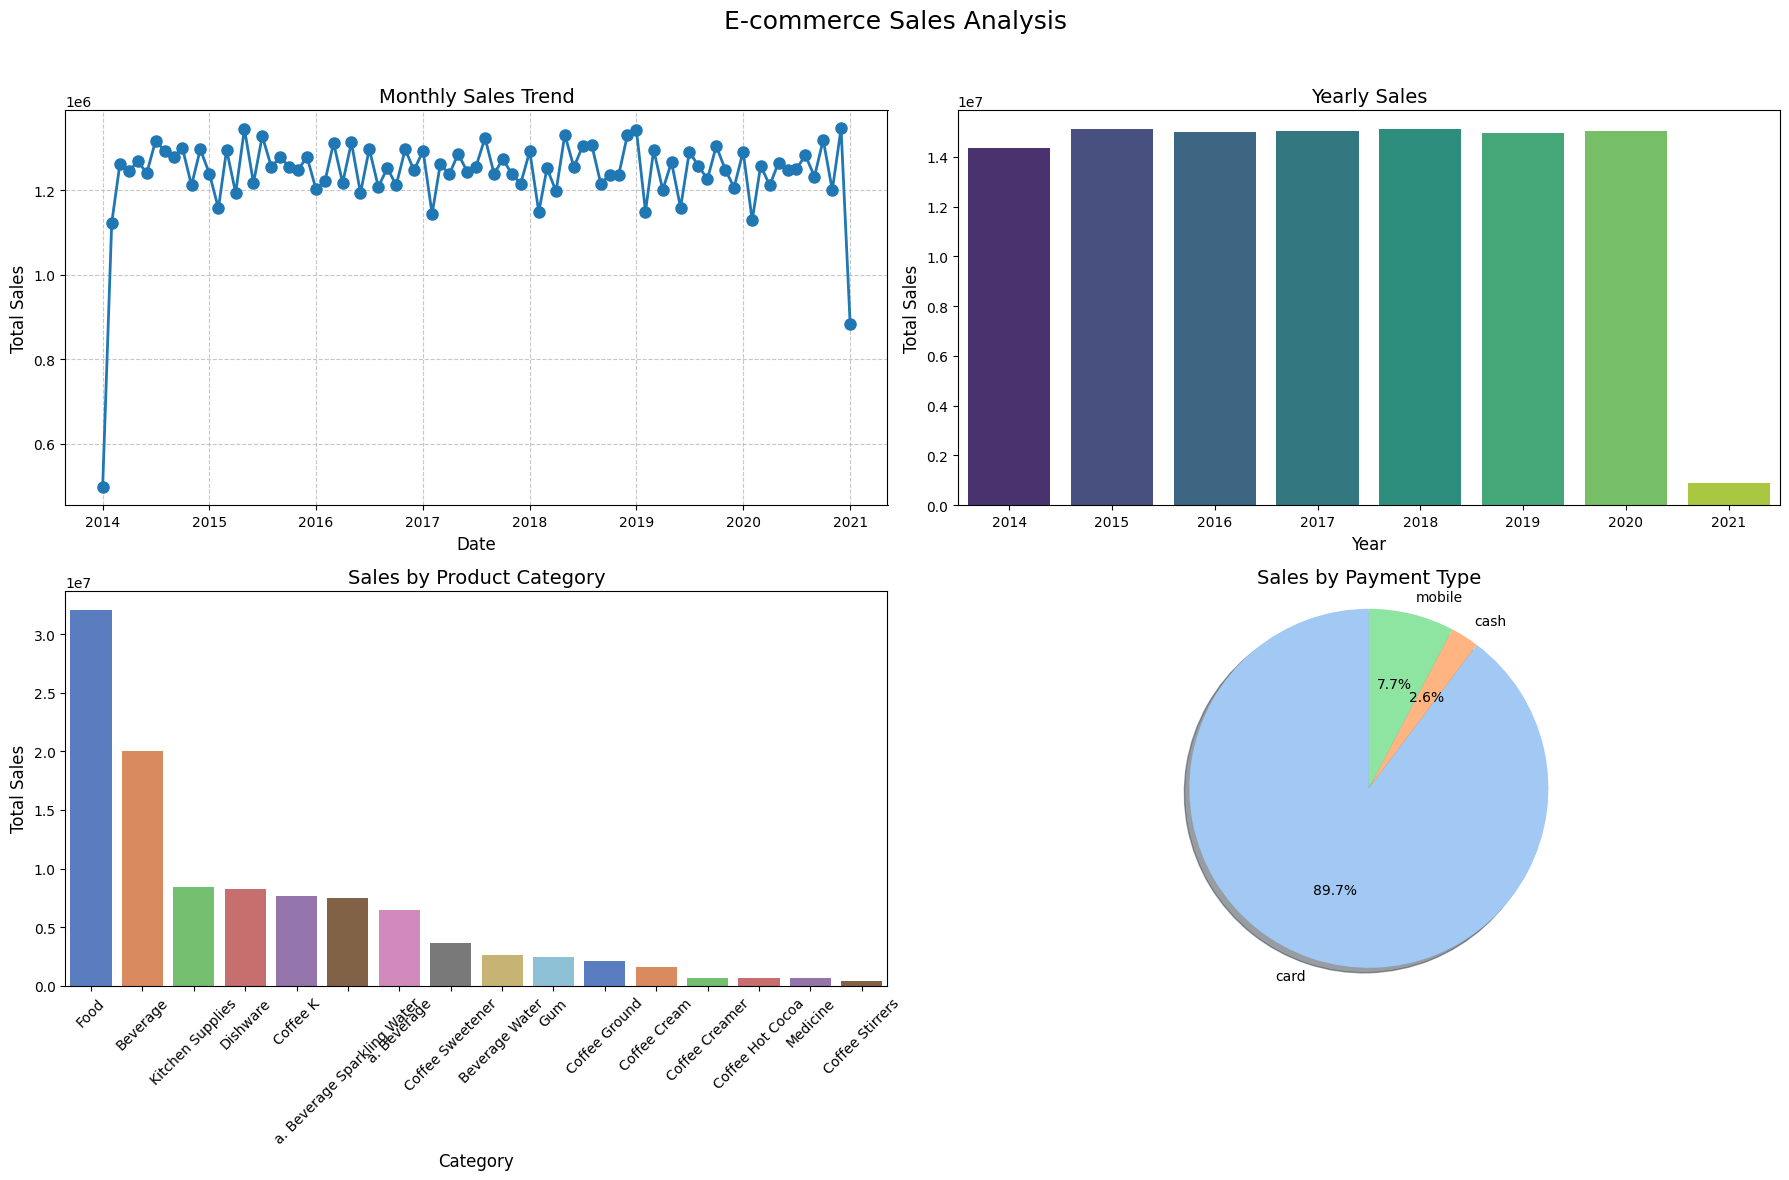

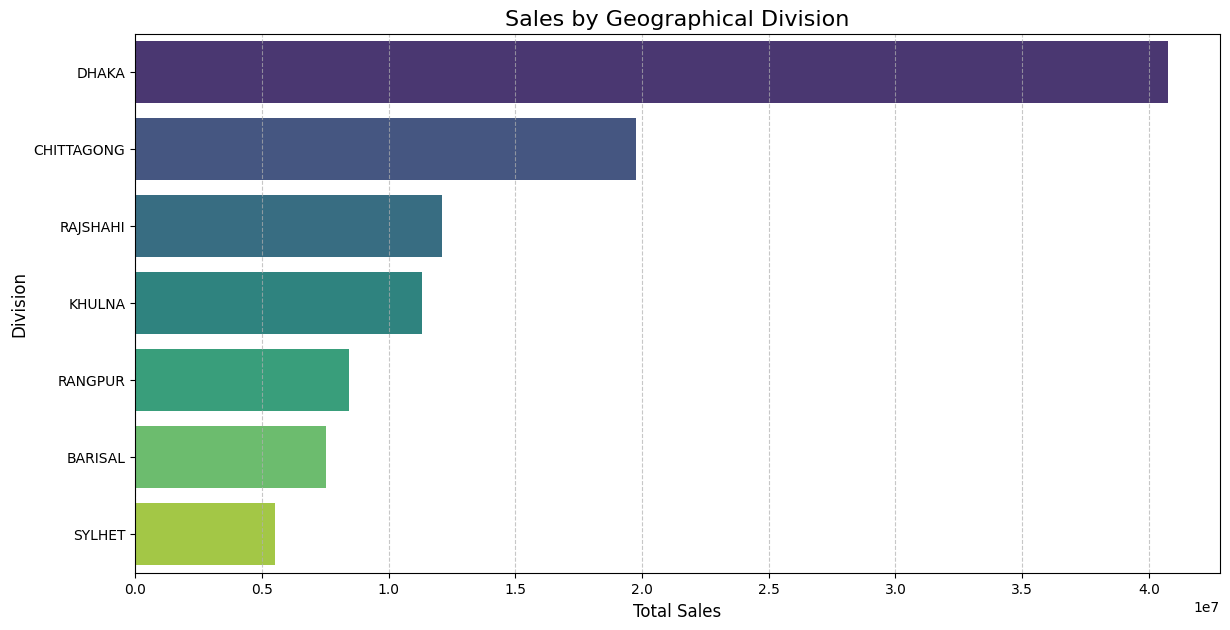

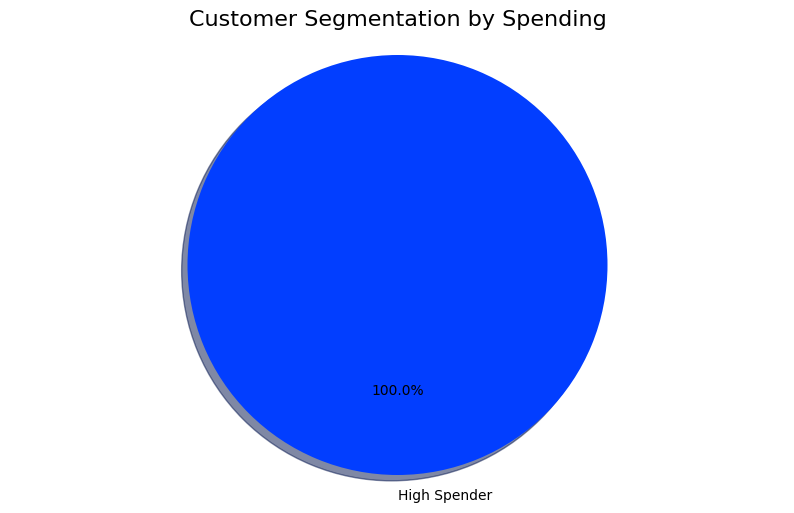

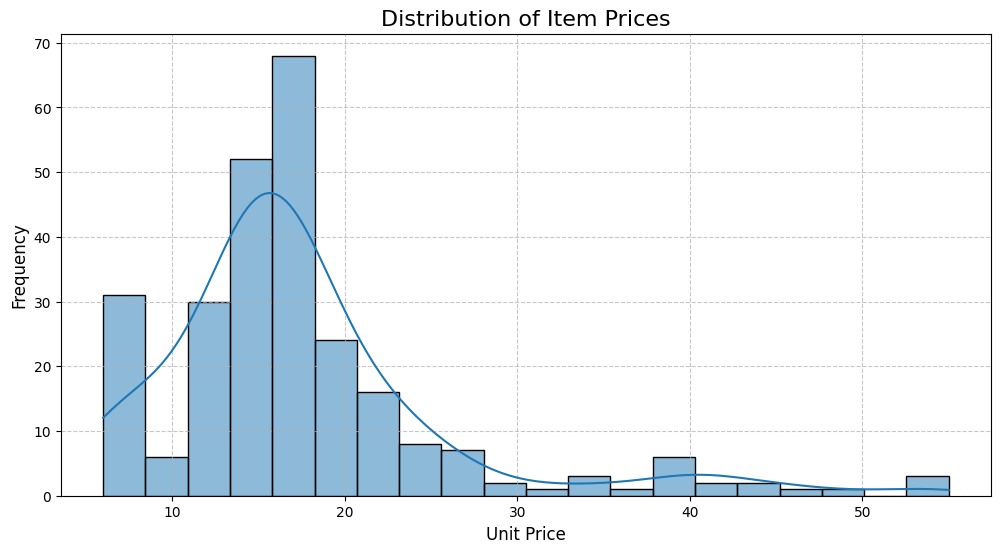

In [16]:
plots = generate_all_plots(df)

## Product Performance

In [17]:

def get_product_performance(clean_df):
    """
    Calculate total quantity sold for each item, sorted in descending order.
    Equivalent to the SQL query:

    SELECT i.item_name, SUM(f.quantity) as total_quantity_sold
    FROM fact f
    JOIN item i ON f.item_key = i.item_key
    GROUP BY i.item_name
    ORDER BY total_quantity_sold DESC
    """
    # Get the fact and item dataframes
    fact_df = clean_df['fact']
    item_df = clean_df['item']

    # Merge the fact and item dataframes on item_key
    merged_df = pd.merge(
        fact_df,
        item_df,
        on='item_key',
        how='inner'
    )

    # Group by item_name and sum the quantities
    product_performance = merged_df.groupby('item_name')['quantity'].sum().reset_index()

    # Rename the sum column to match the SQL query
    product_performance = product_performance.rename(columns={'quantity': 'total_quantity_sold'})

    # Sort by total_quantity_sold in descending order
    product_performance = product_performance.sort_values(by='total_quantity_sold', ascending=False)

    # Reset the index to start from 1 instead of 0
    product_performance.index = range(1, len(product_performance) + 1)

    return product_performance

# Example usage:
product_performance = get_product_performance(clean_df)
print(product_performance)

                               item_name  total_quantity_sold
1                     Pepsi - 12 oz cans                46837
2    Muscle Milk Protein Shake Van. 11oz                45665
3                Coke Classic 12 oz cans                45501
4                 Diet Coke - 12 oz cans                45202
5                    Sprite - 12 oz cans                45140
..                                   ...                  ...
255        Dole Fruit in Gel Cups 4.3 oz                21818
256      La Croix Sparkling Orange 12 oz                21817
257        Hershey Factory Favorites Mix                21741
258                   Monster Java 15 oz                21698
259               Snyders Pretzels Minis                21647

[259 rows x 2 columns]


**Top Performers:** The leading products in terms of quantity sold are *'Pepsi - 12 oz cans'*, followed closely by *'Muscle Milk Protein Shake Van. 11oz'*, *'Coke Classic 12 oz cans'*, *'Diet Coke - 12 oz cans'*, and *'Sprite - 12 oz cans'*. These items seem to have significantly higher sales volumes compared to the rest, indicating a strong customer preference or effective sales strategies for these products.

**Product Variety:** The range of products is quite diverse, including soft drinks, protein shakes, sugar canisters, peanut butter cups, and more, suggesting a broad inventory appealing to varied customer tastes and needs.

**Sales Distribution:** The sales distribution is relatively uneven, with a sharp drop-off as we move down the list of products. While a few items have very high sales, the majority have moderate to lower sales volumes.

**Potential Focus Areas:** The high sales of certain beverages like Pepsi and Coke suggest that soft drinks are popular items, potentially driving a significant portion of the revenue. This might be an area for the store to focus on for promotions or inventory management.

**Sales Strategy Insights:** The data might be used to optimize inventory by ensuring that top-selling products are always in stock, while re-evaluating the carrying costs of the lower-selling items.

# Customer Lifetime Value Prediction ( CLV Model)

## Pipeline Preview

In [18]:
def clv_prediction_pipeline(clean_df):
    """
    Full pipeline for Customer Lifetime Value prediction using clean dataframes.

    Parameters:
    -----------
    clean_df : dict
        Dictionary containing the cleaned dataframes ('customer', 'fact', 'time', etc.)

    Returns:
    --------
    dict
        Dictionary containing model, customer segments, and evaluation metrics
    """
    print("Starting CLV prediction pipeline...")

    # Step 1: Feature Engineering
    customer_features = engineer_clv_features(clean_df)

    # Step 2: Train the model
    model, evaluation = train_evaluate_clv_model(customer_features)

    # Step 3: Generate customer segments
    customer_segments = segment_customers(customer_features, model)

    # Step 4: Generate insights
    insights = generate_business_insights(customer_segments, clean_df)

    # Step 5: Save results
    save_results(model, customer_segments, customer_features)

    return {
        'model': model,
        'features': customer_features,
        'segments': customer_segments,
        'evaluation': evaluation,
        'insights': insights
    }


## Feature extraction

In [19]:
def engineer_clv_features(clean_df):
    """
    Create features for CLV prediction from the cleaned dataframes.

    Parameters:
    -----------
    clean_df : dict
        Dictionary containing the cleaned dataframes

    Returns:
    --------
    DataFrame
        DataFrame with customer features for CLV prediction
    """
    print("Engineering customer features...")

    # Get the required dataframes
    fact_df = clean_df['fact'].copy()
    customer_df = clean_df['customer'].copy()
    time_df = clean_df['time'].copy()

    # Join fact with time data
    print("Joining fact and time data...")
    fact_time = fact_df.merge(time_df, on='time_key')

    # Ensure date is in datetime format
    if 'date' in fact_time.columns:
        if fact_time['date'].dtype == 'object':
            try:
                fact_time['date'] = pd.to_datetime(fact_time['date'], format='%d-%m-%Y %H:%M', errors='coerce')
            except:
                fact_time['date'] = pd.to_datetime(fact_time['date'], errors='coerce')
    else:
        # If no direct date column, try to build one from year, month, day
        if all(col in fact_time.columns for col in ['year', 'month', 'day']):
            fact_time['date'] = pd.to_datetime(
                fact_time[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1),
                errors='coerce'
            )

    # Calculate reference date (most recent date in the data)
    max_date = fact_time['date'].max()
    print(f"Reference date for recency calculations: {max_date}")

    # Calculate RFM metrics
    print("Calculating RFM (Recency, Frequency, Monetary) metrics...")

    # R: Recency - days since last purchase
    recency = fact_time.groupby('customer_key')['date'].max().reset_index()
    recency['recency_days'] = (max_date - recency['date']).dt.days

    # F: Frequency - count of purchases
    frequency = fact_time.groupby('customer_key').size().reset_index(name='frequency')

    # M: Monetary - spending metrics
    monetary = fact_time.groupby('customer_key').agg(
        total_spent=('total_price', 'sum'),
        avg_transaction=('total_price', 'mean'),
        min_transaction=('total_price', 'min'),
        max_transaction=('total_price', 'max'),
        transactions_stddev=('total_price', 'std')
    ).reset_index()

    # Fill NaN values in stddev (occurs when customer has only one transaction)
    monetary['transactions_stddev'] = monetary['transactions_stddev'].fillna(0)

    # Calculate customer tenure
    tenure = fact_time.groupby('customer_key')['date'].min().reset_index()
    tenure['tenure_days'] = (max_date - tenure['date']).dt.days
    tenure['tenure_months'] = tenure['tenure_days'] / 30.44  # Average days per month

    # Calculate purchase rate (purchases per month)
    customer_features = frequency.copy()
    customer_features = customer_features.merge(tenure[['customer_key', 'tenure_days', 'tenure_months']], on='customer_key')
    customer_features['purchase_rate'] = customer_features['frequency'] / customer_features['tenure_months'].clip(lower=1)

    # Merge all the metrics
    customer_features = customer_features.merge(recency[['customer_key', 'recency_days']], on='customer_key')
    customer_features = customer_features.merge(monetary, on='customer_key')

    # Calculate additional derived features
    print("Calculating additional derived features...")

    # Spending velocity (spend per day)
    customer_features['spend_per_day'] = customer_features['total_spent'] / customer_features['tenure_days'].clip(lower=1)

    # Spending consistency (coefficient of variation - lower means more consistent spending)
    # Use stddev/mean as measure of consistency
    customer_features['spending_cv'] = customer_features['transactions_stddev'] / customer_features['avg_transaction'].clip(lower=0.01)

    # Recency ratio (recency days / tenure days) - lower is better
    customer_features['recency_ratio'] = customer_features['recency_days'] / customer_features['tenure_days'].clip(lower=1)

    # Purchase density (purchases per dollar)
    customer_features['purchases_per_dollar'] = customer_features['frequency'] / customer_features['total_spent'].clip(lower=1)

    # Create simplified CLV target based on RFM metrics
    # This will be our training target
    print("Creating target variable for CLV model...")

    # Calculate average monthly spend
    customer_features['monthly_spend'] = customer_features['total_spent'] / customer_features['tenure_months'].clip(lower=1)

    # Calculate retention probability based on recency and frequency
    recency_factor = 1 / (1 + customer_features['recency_days'] / 30)  # Decay with recency
    frequency_factor = np.log1p(customer_features['frequency']) / 5  # Increase with frequency
    customer_features['retention_factor'] = (recency_factor + frequency_factor).clip(0.1, 0.9)

    # Calculate simple 12-month CLV
    customer_features['clv_12_month'] = customer_features['monthly_spend'] * 12 * customer_features['retention_factor']

    # Merge with customer demographics if available
    if 'customer_key' in customer_df.columns:
        print("Adding customer demographics...")
        customer_features = customer_features.merge(
            customer_df[['customer_key', 'name']],
            on='customer_key',
            how='left'
        )

    # Log some statistics
    print(f"Created features for {len(customer_features)} customers")
    print(f"Average 12-month CLV: ${customer_features['clv_12_month'].mean():.2f}")

    return customer_features

In [20]:
fact_df = clean_df['fact'].copy()
time_df = clean_df['time'].copy()
fact_time = fact_df.merge(time_df, on='time_key')
fact_time.head(10)
frequency = fact_time.groupby('customer_key').size().reset_index(name='frequency')
frequency.head(10)

,customer_key,frequency
0,C000001,82
1,C000002,103
2,C000003,108
3,C000004,118
4,C000005,108
5,C000006,109
6,C000007,121
7,C000008,105
8,C000009,107
9,C000010,101


## Training model

In [21]:
def train_evaluate_clv_model(customer_features):
    """
    Train and evaluate a CLV prediction model using SVM.

    Parameters:
    -----------
    customer_features : DataFrame
        DataFrame with customer features for CLV prediction

    Returns:
    --------
    tuple
        (trained model, evaluation metrics)
    """
    print("Training CLV prediction model using SVM...")

    # Clean data - remove any rows with missing or infinite values
    clean_features = customer_features.replace([np.inf, -np.inf], np.nan).dropna()
    print(f"Using {len(clean_features)} clean customer records for modeling")

    # Define features to use
    features = [
        'recency_days', 'frequency', 'purchase_rate',
        'total_spent', 'avg_transaction', 'tenure_days',
        'spend_per_day', 'spending_cv', 'recency_ratio',
        'purchases_per_dollar'
    ]

    # Split data into features and target
    X = clean_features[features]
    y = clean_features['clv_12_month']

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    # Create a pipeline with preprocessing and SVM model
    clv_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scaling is crucial for SVM
        ('model', SVR(
            kernel='rbf',  # Radial Basis Function kernel
            C=100,         # Regularization parameter
            epsilon=0.1,   # Epsilon in the epsilon-SVR model
            gamma='scale'  # Kernel coefficient
        ))
    ])

    # Optional: Hyperparameter tuning with cross-validation
    param_grid = {
        'model__C': [10, 100, 1000],
        'model__gamma': ['scale', 'auto', 0.1, 0.01],
        'model__epsilon': [0.1, 0.2, 0.5]
    }

    # Uncomment for hyperparameter tuning (will be slower)
    # grid_search = GridSearchCV(
    #     clv_pipeline, param_grid, cv=5,
    #     scoring='neg_mean_absolute_error',
    #     n_jobs=-1
    # )
    # grid_search.fit(X_train, y_train)
    # best_pipeline = grid_search.best_estimator_
    # print(f"Best parameters: {grid_search.best_params_}")

    # Train the model (use this if not doing hyperparameter tuning)
    clv_pipeline.fit(X_train, y_train)
    best_pipeline = clv_pipeline

    # Evaluate the model
    y_pred = best_pipeline.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Model Evaluation:")
    print(f"Mean Absolute Error: ${mae:.2f}")
    print(f"Root Mean Squared Error: ${rmse:.2f}")
    print(f"R² Score: {r2:.3f}")

    # Visualizations
    # Plot predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual CLV ($)')
    plt.ylabel('Predicted CLV ($)')
    plt.title('Predicted vs Actual Customer Lifetime Value')
    plt.grid(True)

    # Since SVM doesn't provide feature importance directly, use permutation importance
    from sklearn.inspection import permutation_importance

    result = permutation_importance(
        best_pipeline, X_test, y_test,
        n_repeats=10, random_state=42
    )

    importance_values = result.importances_mean
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importance_values
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importance (Permutation Method):")
    for i, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance for CLV Prediction (SVM Model)')
    plt.grid(True, axis='x')
    plt.tight_layout()

    return best_pipeline, {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'importance': importance_df,
        'actual_vs_predicted': {
            'actual': y_test.values,
            'predicted': y_pred
        }
    }

## Segment customers

In [22]:
def segment_customers(customer_features, model):
    """
    Segment customers based on their predicted CLV.

    Parameters:
    -----------
    customer_features : DataFrame
        DataFrame with customer features
    model : Pipeline
        Trained CLV prediction model

    Returns:
    --------
    DataFrame
        DataFrame with customer segments
    """
    print("Segmenting customers based on CLV...")

    # Create a copy to avoid modifying the original
    segments = customer_features.copy()

    # Define segment thresholds
    # These can be adjusted based on your business context
    def clv_segment(value):
        if value <= 500:
            return 'Low Value'
        elif value <= 1400:
            return 'Medium Value'
        elif value <= 1800:
            return 'High Value'
        else:
            return 'Top Value'

    # Apply segmentation
    segments['clv_segment'] = segments['clv_12_month'].apply(clv_segment)

    # Count customers in each segment
    segment_counts = segments['clv_segment'].value_counts()
    segment_value = segments.groupby('clv_segment')['clv_12_month'].sum()

    print("\nCustomer Segment Distribution:")
    for segment, count in segment_counts.items():
        total_value = segment_value[segment]
        percent = count / len(segments) * 100
        print(f"{segment}: {count} customers ({percent:.1f}%), ${total_value:.2f} total CLV")

    # Visualize segment distribution
    plt.figure(figsize=(10, 6))
    colors = ['lightcoral', 'lightskyblue', 'lightgreen', 'gold']
    segments['clv_segment'].value_counts().plot(
        kind='bar',
        color=colors
    )
    plt.title('Customer Distribution by CLV Segment')
    plt.xlabel('Segment')
    plt.ylabel('Number of Customers')
    plt.grid(True, axis='y')
    plt.tight_layout()

    # Visualize value distribution by segment
    plt.figure(figsize=(10, 6))
    segments.groupby('clv_segment')['clv_12_month'].sum().plot(
        kind='pie',
        autopct='%1.1f%%',
        colors=colors,
        shadow=True
    )
    plt.title('CLV Distribution by Customer Segment')
    plt.ylabel('')
    plt.tight_layout()


    return segments

## Business Insight

In [23]:
def generate_business_insights(customer_segments, clean_df):
    """
    Generate business insights based on CLV segments.

    Parameters:
    -----------
    customer_segments : DataFrame
        DataFrame with customer segments
    clean_df : dict
        Dictionary containing the cleaned dataframes

    Returns:
    --------
    dict
        Dictionary with business insights
    """
    print("Generating business insights from CLV analysis...")

    insights = {}

    # 1. Top customer identification
    top_customers = customer_segments.sort_values('clv_12_month', ascending=False).head(10)
    if 'name' in top_customers.columns:
        insights['top_customers'] = top_customers[['customer_key', 'name', 'clv_12_month', 'clv_segment']]
    else:
        insights['top_customers'] = top_customers[['customer_key', 'clv_12_month', 'clv_segment']]

    print("\nTop 10 Customers by CLV:")
    print(insights['top_customers'])

    # 2. Marketing resource allocation
    high_value_segments = ['High Value', 'Top Value']
    high_value_customers = customer_segments[customer_segments['clv_segment'].isin(high_value_segments)]
    high_value_count = len(high_value_customers)
    high_value_pct = high_value_count / len(customer_segments) * 100
    high_value_clv = high_value_customers['clv_12_month'].sum()
    high_value_avg = high_value_customers['clv_12_month'].mean()

    insights['high_value_customers'] = {
        'count': high_value_count,
        'percentage': high_value_pct,
        'total_clv': high_value_clv,
        'average_clv': high_value_avg
    }

    print(f"\nHigh Value Customer Analysis:")
    print(f"- {high_value_count} high-value customers ({high_value_pct:.1f}% of base)")
    print(f"- Represent ${high_value_clv:.2f} in projected annual value")
    print(f"- Average high-value customer CLV: ${high_value_avg:.2f}")

    # 3. Customer acquisition strategy
    average_clv = customer_segments['clv_12_month'].mean()
    suggested_cac = average_clv * 0.3  # Common rule: CAC should be 1/3 of CLV

    insights['acquisition_strategy'] = {
        'average_clv': average_clv,
        'suggested_cac': suggested_cac
    }

    print(f"\nCustomer Acquisition Strategy:")
    print(f"- Average 12-month CLV: ${average_clv:.2f}")
    print(f"- Suggested maximum customer acquisition cost: ${suggested_cac:.2f}")

    # 4. If we have transaction and item data, analyze purchasing patterns by segment
    if all(key in clean_df for key in ['fact', 'item']):
        try:
            fact_df = clean_df['fact'].copy()
            item_df = clean_df['item'].copy()

            # Ensure consistent column naming
            if 'coustomer_key' in fact_df.columns and 'customer_key' not in fact_df.columns:
                fact_df = fact_df.rename(columns={'coustomer_key': 'customer_key'})

            # Join fact with customer segments and items
            segment_purchases = fact_df.merge(
                customer_segments[['customer_key', 'clv_segment']],
                on='customer_key'
            )

            segment_purchases = segment_purchases.merge(
                item_df, on='item_key'
            )

            # Analyze popular categories by segment
            if 'desc' in segment_purchases.columns:
                # Extract category from description (simplified approach)
                segment_purchases['category'] = segment_purchases['desc'].str.split('-', expand=True)[0].str.strip()

                segment_categories = segment_purchases.groupby(['clv_segment', 'category'])['total_price'].sum().reset_index()
                top_categories = segment_categories.sort_values(['clv_segment', 'total_price'], ascending=[True, False])
                top_categories_per_segment = top_categories.groupby('clv_segment').head(3)

                insights['category_preferences'] = top_categories_per_segment

                print("\nPopular Categories by Customer Segment:")
                for segment in high_value_segments:
                    segment_data = top_categories_per_segment[top_categories_per_segment['clv_segment'] == segment]
                    if not segment_data.empty:
                        print(f"\n{segment} customers prefer:")
                        for i, row in segment_data.iterrows():
                            print(f"- {row['category']}: ${row['total_price']:.2f}")

        except Exception as e:
            print(f"Could not analyze purchasing patterns: {e}")

    return insights

## Save model

In [24]:
def save_results(model, customer_segments, customer_features):
    """
    Save the CLV model, segments, and features.

    Parameters:
    -----------
    model : Pipeline
        Trained CLV prediction model
    customer_segments : DataFrame
        DataFrame with customer segments
    customer_features : DataFrame
        DataFrame with customer features
    """
    # Save model
    model_filename = f"clv_model.joblib"
    joblib.dump(model, model_filename)

    # Save customer segments
    segments_filename = f"customer_segments.csv"
    customer_segments.to_csv(segments_filename, index=False)

    print(f"\nSaved results:")
    print(f"- Model: {model_filename}")
    print(f"- Customer Segments: {segments_filename}")

## Result

Starting CLV prediction pipeline...
Engineering customer features...
Joining fact and time data...
Reference date for recency calculations: 2021-01-23 04:38:00
Calculating RFM (Recency, Frequency, Monetary) metrics...
Calculating additional derived features...
Creating target variable for CLV model...
Adding customer demographics...
Created features for 9191 customers
Average 12-month CLV: $1486.87
Training CLV prediction model using SVM...
Using 9191 clean customer records for modeling
Model Evaluation:
Mean Absolute Error: $1.09
Root Mean Squared Error: $8.27
R² Score: 0.998

Feature Importance (Permutation Method):
spend_per_day: 0.2404
total_spent: 0.2370
purchase_rate: 0.1567
frequency: 0.1528
purchases_per_dollar: 0.0951
avg_transaction: 0.0949
recency_days: 0.0238
recency_ratio: 0.0238
tenure_days: 0.0034
spending_cv: 0.0003
Segmenting customers based on CLV...

Customer Segment Distribution:
High Value: 5788 customers (63.0%), $9019552.33 total CLV
Medium Value: 2978 customers 

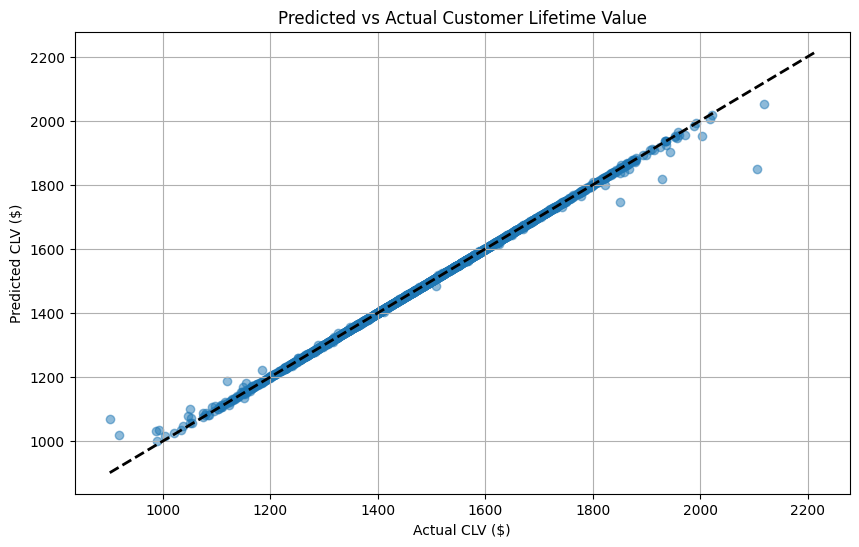

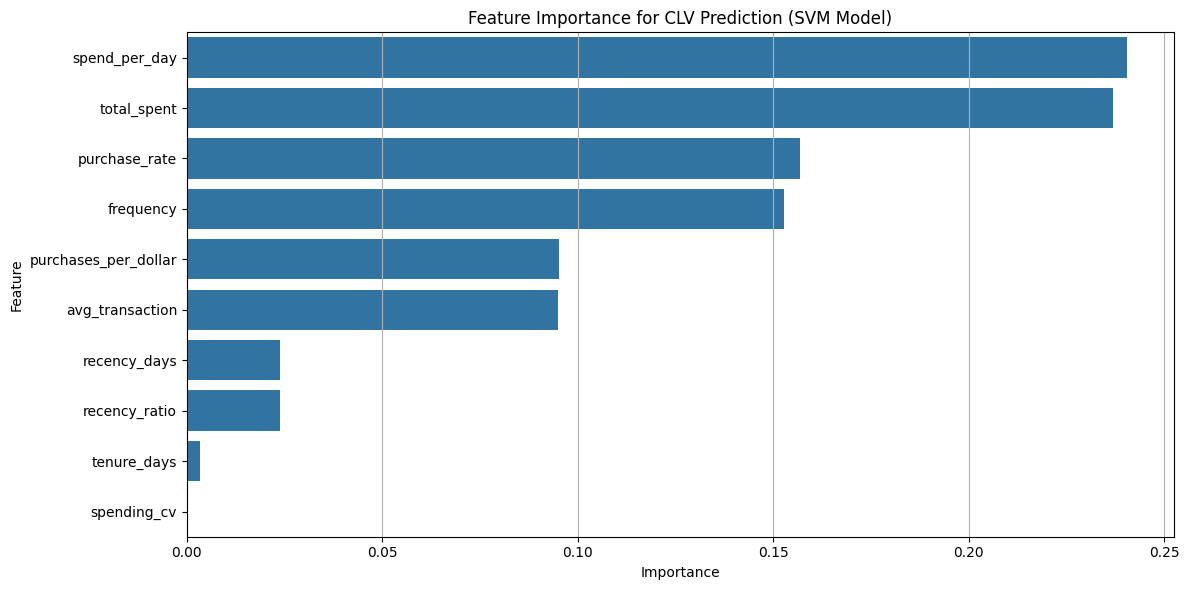

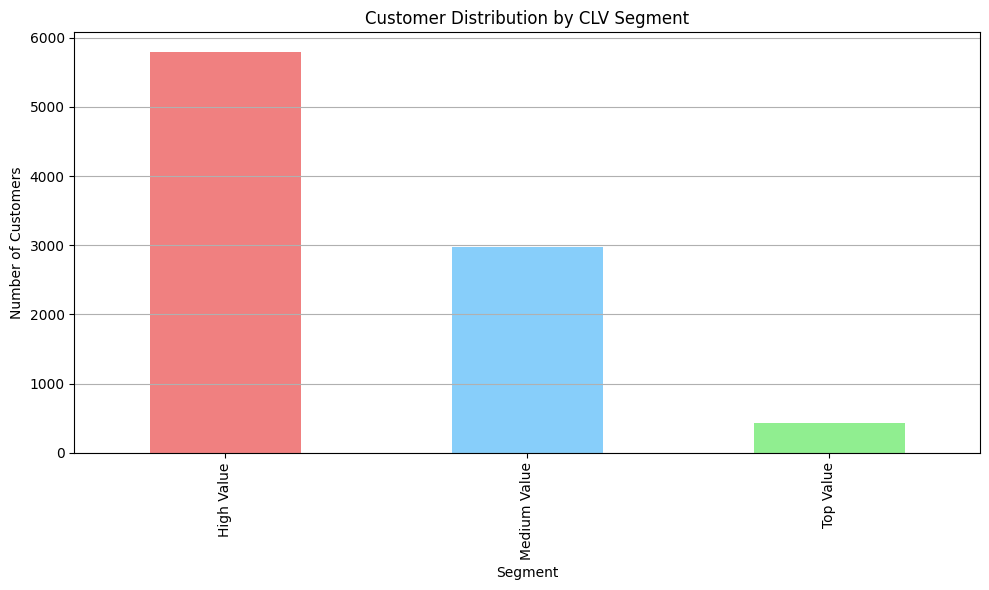

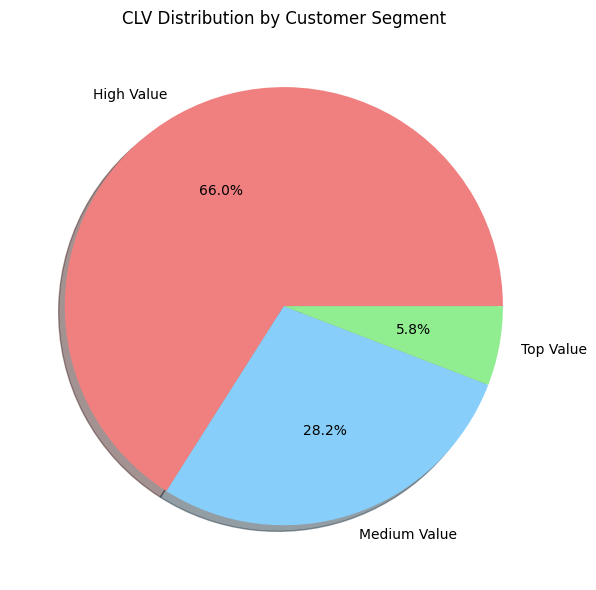

In [25]:
# Run the pipeline with your cleaned dataframes
results = clv_prediction_pipeline(clean_df)

# Access the results
model = results['model']

# Clustering base on behavioral features.

In [26]:
def cluster_customers(customer_features, n_clusters= None, method='kmeans'):
    """
    Cluster customers based on their behavioral features.

    Parameters:
    -----------
    customer_features : DataFrame
        DataFrame with customer features from engineer_clv_features
    n_clusters : int
        Number of clusters to create (default: 4)
    method : str
        Clustering method to use: 'kmeans' or 'hierarchical' (default: 'kmeans')

    Returns:
    --------
    DataFrame
        DataFrame with original features plus cluster assignments
    """

    print(f"Clustering customers using {method} method...")

    # Select features for clustering
    cluster_features = [
        'recency_days', 'frequency', 'purchase_rate',
        'total_spent', 'avg_transaction', 'tenure_days',
        'spend_per_day', 'spending_cv', 'recency_ratio'
    ]

    # Remove any rows with NaN values
    data_for_clustering = customer_features[cluster_features].dropna()

    # Get corresponding customer keys
    valid_customers = customer_features.loc[data_for_clustering.index, 'customer_key']

    # Scale the data (important for clustering)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_for_clustering)

    # Optional: Find optimal number of clusters
    if n_clusters is None:
        # Calculate silhouette scores for different numbers of clusters
        silhouette_scores = []
        k_range = range(2, 11)

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(scaled_data)
            score = silhouette_score(scaled_data, cluster_labels)
            silhouette_scores.append(score)
            print(f"K={k}, Silhouette Score: {score:.4f}")

        # Plot silhouette scores
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, silhouette_scores, 'o-')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Silhouette Score')
        plt.title('Optimal Number of Clusters')
        plt.grid(True)
        plt.savefig('optimal_clusters.png')

        # Choose k with highest silhouette score
        best_k = k_range[np.argmax(silhouette_scores)]
        print(f"Optimal number of clusters: {best_k}")
        n_clusters = best_k

    # Perform clustering
    if method == 'kmeans':
        # K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(scaled_data)

        # Get cluster centers
        cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

    elif method == 'hierarchical':
        # Hierarchical clustering
        hclust = AgglomerativeClustering(n_clusters=n_clusters)
        cluster_labels = hclust.fit_predict(scaled_data)

        # No direct way to get cluster centers in hierarchical clustering
        # Calculate mean values for each cluster instead
        cluster_centers = np.zeros((n_clusters, len(cluster_features)))
        for i in range(n_clusters):
            mask = (cluster_labels == i)
            cluster_centers[i] = data_for_clustering.iloc[mask].mean().values

    # Create a DataFrame with cluster centers
    cluster_profile = pd.DataFrame(
        cluster_centers,
        columns=cluster_features
    )

    # Add cluster numbers
    cluster_profile['cluster'] = [f'Cluster {i}' for i in range(n_clusters)]

    # Create a dictionary mapping customer_key to cluster
    customer_clusters = dict(zip(valid_customers, cluster_labels))

    # Add cluster labels to original data
    clustered_customers = customer_features.copy()
    clustered_customers['cluster'] = clustered_customers['customer_key'].map(customer_clusters)

    # Fill NaN values in cluster (for customers that couldn't be clustered)
    if clustered_customers['cluster'].isna().any():
        print(f"Note: {clustered_customers['cluster'].isna().sum()} customers couldn't be clustered due to missing values")
        # Assign them to a special "Unclustered" category
        clustered_customers['cluster'] = clustered_customers['cluster'].fillna(-1)

    # Convert cluster to string labels
    clustered_customers['cluster_name'] = clustered_customers['cluster'].map(
        lambda x: f'Cluster {int(x)}' if x >= 0 else 'Unclustered'
    )

    return clustered_customers, cluster_profile

In [27]:
def plot_customer_clusters(clustered_customers):
    """
    Create visualizations of customer clusters.
    """
    # 1. Cluster distribution
    plt.figure(figsize=(10, 6))
    cluster_counts = clustered_customers['cluster_name'].value_counts()
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
    plt.title('Customer Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('cluster_distribution.png')

    # 2. RFM characteristics by cluster
    plt.figure(figsize=(12, 8))

    # Calculate mean values for key metrics by cluster
    cluster_summary = clustered_customers.groupby('cluster_name').agg({
        'recency_days': 'mean',
        'frequency': 'mean',
        'total_spent': 'mean',
        'clv_12_month': 'mean'
    }).reset_index()

    # Create a radar chart (parallel coordinates) for cluster profiles
    from pandas.plotting import parallel_coordinates

    # Scale values for better visualization
    radar_data = cluster_summary.copy()
    for col in ['recency_days', 'frequency', 'total_spent', 'clv_12_month']:
        radar_data[col] = (radar_data[col] - radar_data[col].min()) / (radar_data[col].max() - radar_data[col].min())

    plt.figure(figsize=(12, 8))
    parallel_coordinates(radar_data, 'cluster_name', colormap='viridis')
    plt.title('Customer Cluster Profiles')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('cluster_profiles.png')

    # 3. PCA visualization
    # Apply PCA to reduce to 2 dimensions for visualization
    features = [
        'recency_days', 'frequency', 'purchase_rate',
        'total_spent', 'avg_transaction', 'spend_per_day'
    ]

    # Filter out unclustered customers
    valid_data = clustered_customers[clustered_customers['cluster'] >= 0].copy()

    # Apply PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(valid_data[features])

    # Create a dataframe with the principal components
    pca_df = pd.DataFrame(
        data=principal_components,
        columns=['PC1', 'PC2']
    )
    pca_df['cluster'] = valid_data['cluster_name'].values

    # Plot PCA results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', s=50, alpha=0.7)
    plt.title('Customer Clusters (PCA Visualization)')
    plt.tight_layout()
    plt.savefig('cluster_pca.png')

    return

## Result

Engineering customer features...
Joining fact and time data...
Reference date for recency calculations: 2021-01-23 04:38:00
Calculating RFM (Recency, Frequency, Monetary) metrics...
Calculating additional derived features...
Creating target variable for CLV model...
Adding customer demographics...
Created features for 9191 customers
Average 12-month CLV: $1486.87
Clustering customers using kmeans method...
K=2, Silhouette Score: 0.2380
K=3, Silhouette Score: 0.2418
K=4, Silhouette Score: 0.1757
K=5, Silhouette Score: 0.1728
K=6, Silhouette Score: 0.1793
K=7, Silhouette Score: 0.1800
K=8, Silhouette Score: 0.1623
K=9, Silhouette Score: 0.1613
K=10, Silhouette Score: 0.1637
Optimal number of clusters: 3


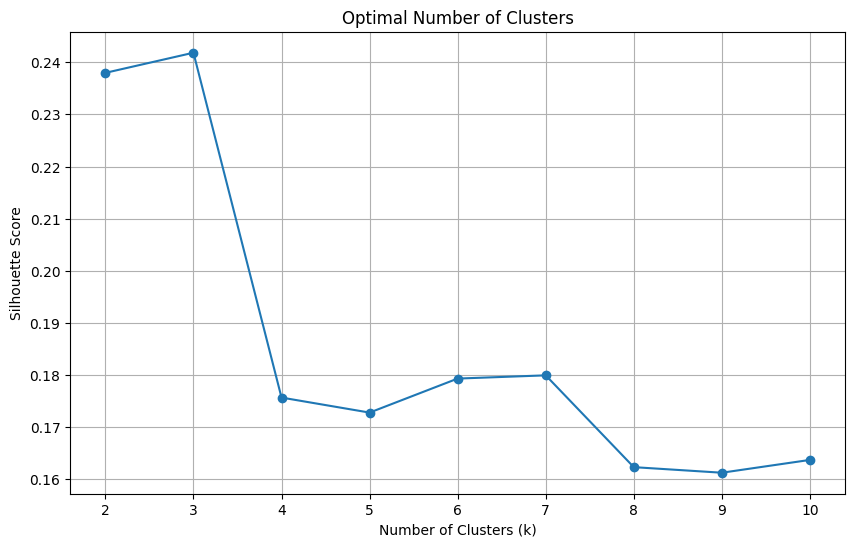

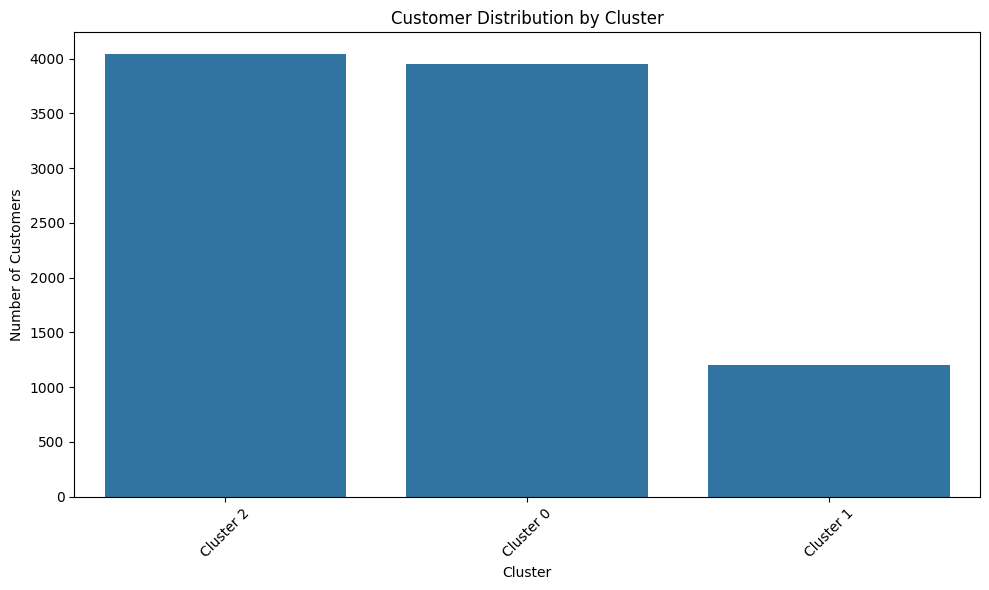

<Figure size 1200x800 with 0 Axes>

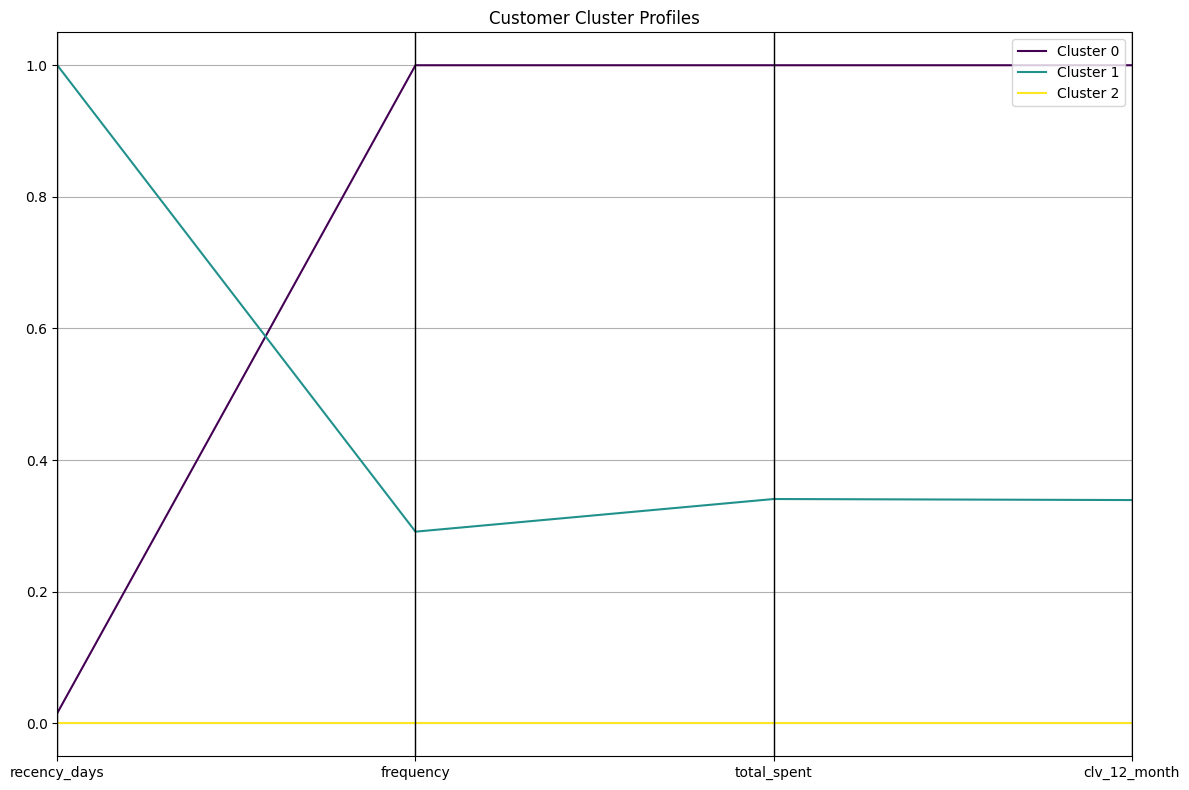

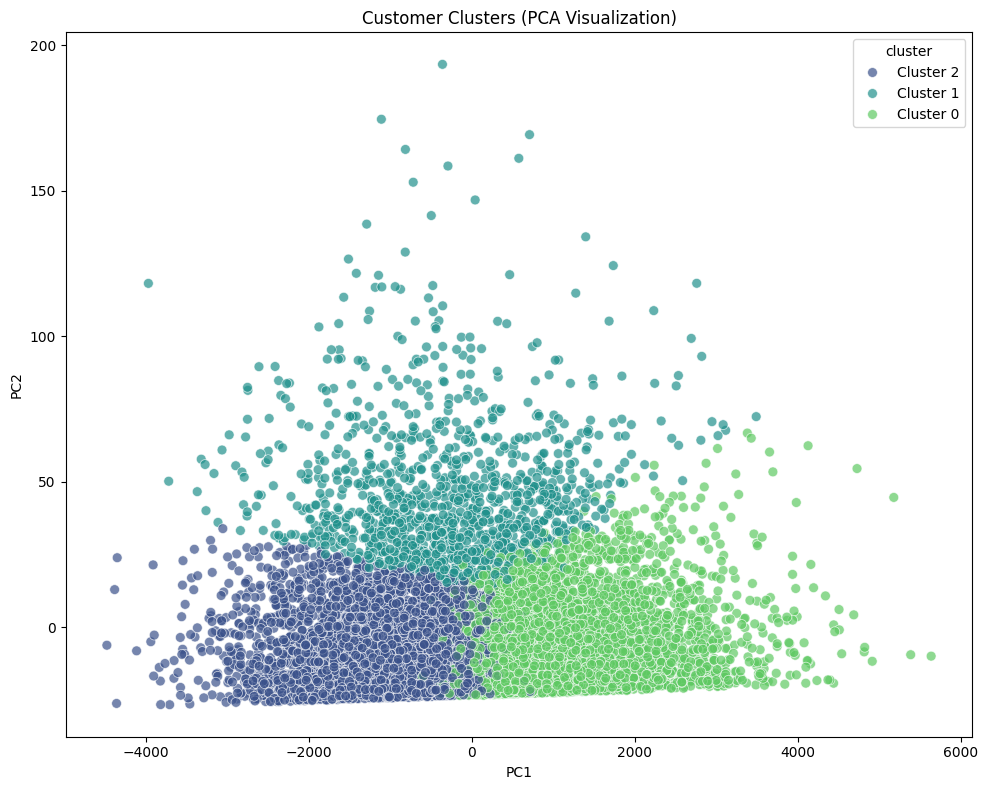

In [28]:
customer_features = engineer_clv_features(clean_df)
clustered_customers, cluster_profiles = cluster_customers(customer_features)
plot_customer_clusters(clustered_customers)

In [29]:
# Print cluster profiles
print(cluster_profiles)

# Interpret clusters with business labels
# Interpret clusters with business labels
def interpret_clusters(cluster_profiles):
    # Example interpretation based on RFM patterns
    interpretations = {}

    for _, row in cluster_profiles.iterrows():
        cluster = row['cluster']
        recency = row['recency_days']
        frequency = row['frequency']
        spend = row['total_spent']

        # Rule-based interpretation
        if recency < 30 and frequency > 100 and spend > 11000:
            label = 'High Value Loyal'
        elif recency < 30 and frequency > 100 and spend > 10000:
            label = 'Mid-High Loyalist'
        elif recency > 10 and spend > 10000:
            label = 'At Risk High Spender'
        else:
            label = 'Others / Unclassified'

        interpretations[cluster] = label

    return interpretations

# Get business interpretations
cluster_interpretations = interpret_clusters(cluster_profiles)
print("\nCluster Business Interpretations:")
for cluster, label in cluster_interpretations.items():
    print(f"{cluster}: {label}")

   recency_days   frequency  purchase_rate   total_spent  avg_transaction  \
0     16.714177  116.850886       1.402593  12643.334114       108.401057   
1     69.009144  106.146301       1.274010  11171.026392       105.365548   
2     15.909856  101.719911       1.221404  10406.518388       102.492363   

   tenure_days  spend_per_day  spending_cv  recency_ratio    cluster  
0  2536.014937       4.985756     0.765804       0.006590  Cluster 0  
1  2536.249377       4.404653     0.758856       0.027216  Cluster 1  
2  2535.163943       4.105040     0.754424       0.006276  Cluster 2  

Cluster Business Interpretations:
Cluster 0: High Value Loyal
Cluster 1: At Risk High Spender
Cluster 2: Mid-High Loyalist


In [30]:
def plot_regional_cluster_distribution(clustered_customers, clean_df, region_level='division'):
    """
    Create visualizations showing the distribution of customer clusters across regions.

    Parameters:
    -----------
    clustered_customers : DataFrame
        DataFrame with customer features and cluster assignments
    clean_df : dict
        Dictionary containing the cleaned dataframes
    region_level : str
        Level of regional aggregation: 'division', 'district', or 'upazila'

    Returns:
    --------
    None (creates visualizations)
    """

    print(f"Analyzing cluster distribution by {region_level}...")

    # Get required dataframes
    fact_df = clean_df['fact'].copy()
    store_df = clean_df['store'].copy()

    # Ensure consistent column naming
    if 'coustomer_key' in fact_df.columns and 'customer_key' not in fact_df.columns:
        fact_df = fact_df.rename(columns={'coustomer_key': 'customer_key'})

    # Link customer transactions to store locations
    # We need to first find which store each customer primarily shops at
    customer_stores = fact_df.groupby(['customer_key', 'store_key']).size().reset_index(name='purchase_count')

    # Get primary store for each customer (store with most purchases)
    primary_store = customer_stores.sort_values('purchase_count', ascending=False).drop_duplicates('customer_key')

    # Link to store information
    customer_regions = primary_store.merge(store_df, on='store_key')

    # Merge with cluster information
    regional_clusters = customer_regions.merge(
        clustered_customers[['customer_key', 'cluster_name']],
        on='customer_key'
    )

    # Create a pivot table of cluster counts by region
    region_cluster_counts = pd.crosstab(
        regional_clusters[region_level],
        regional_clusters['cluster_name']
    )

    # Convert to percentages for better comparison
    region_cluster_pcts = region_cluster_counts.div(region_cluster_counts.sum(axis=1), axis=0) * 100

    # Create stacked bar chart
    plt.figure(figsize=(14, 8))
    region_cluster_pcts.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title(f'Customer Cluster Distribution by {region_level.title()}')
    plt.xlabel(region_level.title())
    plt.ylabel('Percentage of Customers')
    plt.xticks(rotation=45)
    plt.legend(title='Cluster')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f'cluster_distribution_by_{region_level}.png')

    # Create heatmap of absolute counts
    plt.figure(figsize=(14, 8))
    sns.heatmap(region_cluster_counts, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Number of Customers in Each Cluster by {region_level.title()}')
    plt.tight_layout()
    plt.savefig(f'cluster_heatmap_by_{region_level}.png')

    # Calculate which cluster is dominant in each region
    dominant_clusters = region_cluster_counts.idxmax(axis=1).reset_index()
    dominant_clusters.columns = [region_level, 'dominant_cluster']

    print(f"\nDominant Customer Clusters by {region_level.title()}:")
    print(dominant_clusters)

    # Create a map visualization if possible
    # This would require additional geographical data

    # Cross-regional analysis - cluster composition by region
    plt.figure(figsize=(12, 6))
    cluster_region_pcts = region_cluster_counts.div(region_cluster_counts.sum(axis=0), axis=1) * 100
    cluster_region_pcts = cluster_region_pcts.T  # Transpose for better visualization
    cluster_region_pcts.plot(kind='bar', stacked=True, colormap='tab20')
    plt.title(f'Regional Composition of Each Customer Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Percentage of Customers from Each {region_level.title()}')
    plt.xticks(rotation=45)
    plt.legend(title=region_level.title())
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('region_composition_by_cluster.png')

    return region_cluster_counts, dominant_clusters


Analyzing cluster distribution by division...

Dominant Customer Clusters by Division:
     division dominant_cluster
0     Barisal        Cluster 2
1  Chittagong        Cluster 0
2       Dhaka        Cluster 2
3      Khulna        Cluster 0
4    Rajshahi        Cluster 2
5     Rangpur        Cluster 2
6      Sylhet        Cluster 0


<Figure size 1400x800 with 0 Axes>

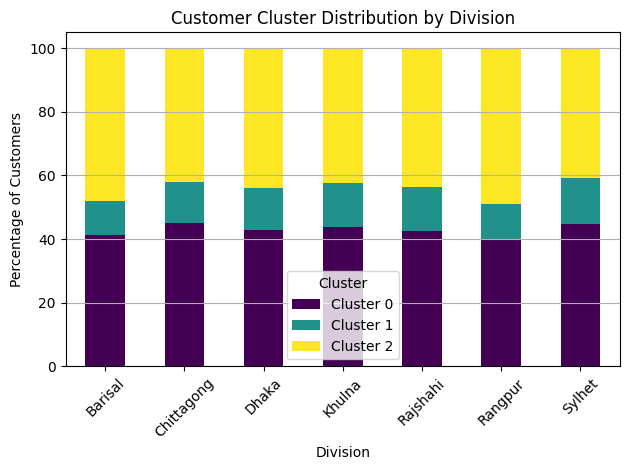

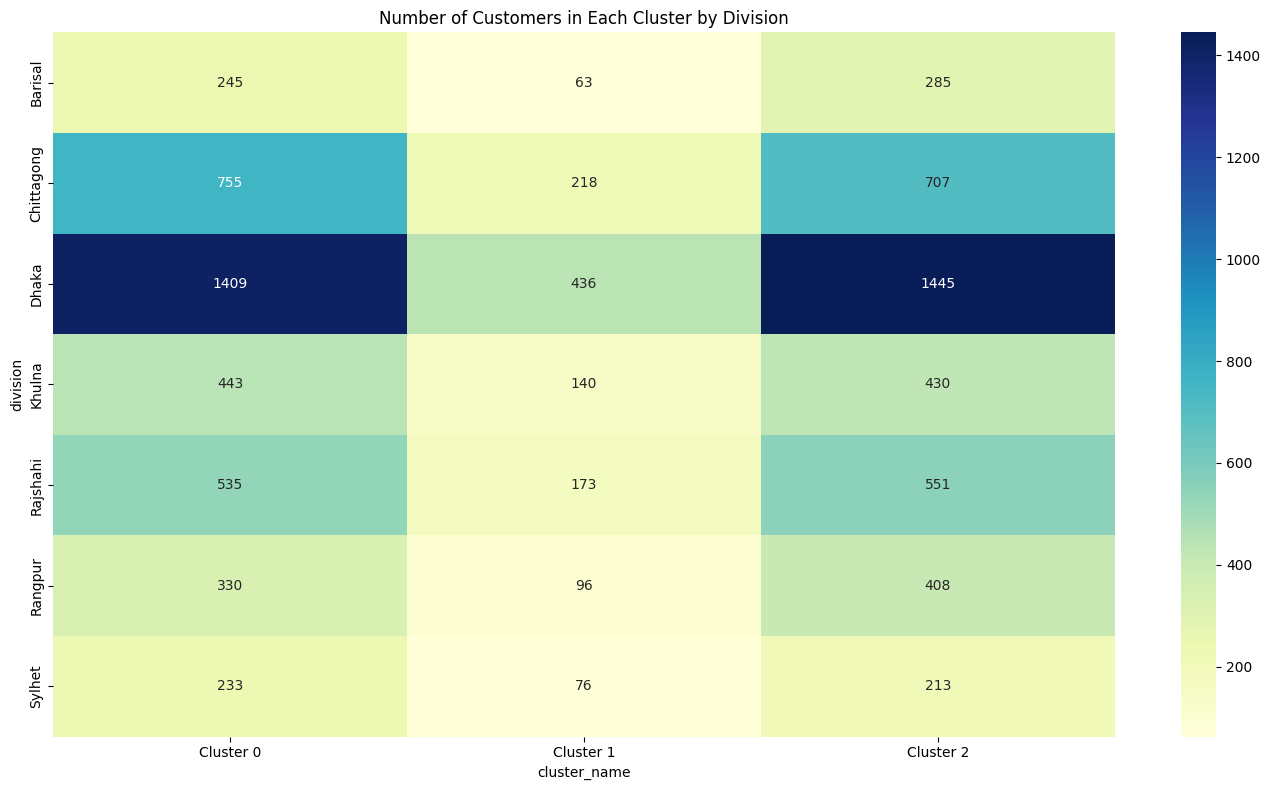

<Figure size 1200x600 with 0 Axes>

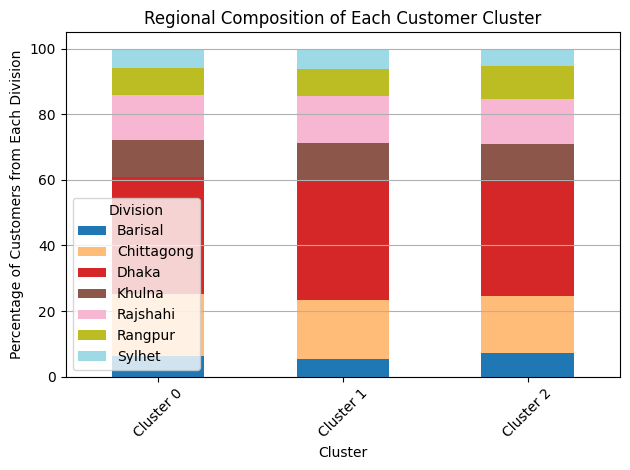

In [31]:
# Example usage:
region_cluster_counts, dominant_clusters = plot_regional_cluster_distribution(
    clustered_customers,
    clean_df,
    region_level='division'
)

# You can call it for different regional levels
# plot_regional_cluster_distribution(clustered_customers, clean_df, region_level='district')
# plot_regional_cluster_distribution(clustered_customers, clean_df, region_level='upazila')

# Recommendation system

In [35]:
def build_user_based_cf_system(clean_df):
    """
    Create a user-based collaborative filtering recommendation system.

    Parameters:
    -----------
    clean_df : dict
        Dictionary containing the cleaned dataframes

    Returns:
    --------
    recommend_function : Function
        A function that returns recommendations for a given customer
    """
    print("Building user-based collaborative filtering system...")

    # Extract required dataframes
    fact_df = clean_df['fact'].copy()
    item_df = clean_df['item'].copy()

    # Ensure consistent column naming
    if 'coustomer_key' in fact_df.columns and 'customer_key' not in fact_df.columns:
        fact_df = fact_df.rename(columns={'coustomer_key': 'customer_key'})

    # Create a purchase matrix (customers × items)
    purchase_matrix = fact_df.pivot_table(
        index='customer_key',
        columns='item_key',
        values='quantity',
        aggfunc='sum',
        fill_value=0
    )

    print(f"Purchase matrix shape: {purchase_matrix.shape}")

    # Calculate user similarity matrix using cosine similarity
    user_similarity = pd.DataFrame(
        cosine_similarity(purchase_matrix),
        index=purchase_matrix.index,
        columns=purchase_matrix.index
    )

    print(f"User similarity matrix shape: {user_similarity.shape}")

    # Recommendation function
    def recommend_for_customer(customer_id, n=5, similarity_threshold=0.0):
        """
        Generate recommendations for a specific customer based on similar users.

        Parameters:
        -----------
        customer_id : str
            Customer key to generate recommendations for
        n : int
            Number of recommendations to return
        similarity_threshold : float
            Minimum similarity score to consider a user as similar

        Returns:
        --------
        DataFrame
            Top N recommended items for the customer
        """
        # Check if customer exists in our data
        if customer_id not in purchase_matrix.index:
            print(f"Customer {customer_id} not found in purchase history")
            return None

        # Get items this customer has already purchased
        customer_purchases = purchase_matrix.loc[customer_id]
        purchased_items = customer_purchases[customer_purchases > 0].index.tolist()

        print(f"Customer {customer_id} has purchased {len(purchased_items)} unique items")

        # Get similarity scores for this customer with all other customers
        if customer_id not in user_similarity.index:
            print(f"Customer {customer_id} not found in similarity matrix")
            return None

        customer_similarities = user_similarity[customer_id].drop(customer_id)  # Remove self-similarity

        # Filter by similarity threshold
        similar_customers = customer_similarities[customer_similarities > similarity_threshold]

        if similar_customers.empty:
            print(f"No similar customers found for {customer_id} with threshold {similarity_threshold}")
            # Fallback: use all other customers but with their original similarity weights
            similar_customers = customer_similarities

        print(f"Found {len(similar_customers)} similar customers for {customer_id}")

        # Initialize recommendation scores
        recommendation_scores = pd.Series(0, index=purchase_matrix.columns)

        # For each similar customer
        for similar_customer, similarity in similar_customers.items():
            # Get items purchased by this similar customer
            similar_customer_purchases = purchase_matrix.loc[similar_customer]

            # Add weighted purchase history to recommendation scores
            recommendation_scores += similarity * similar_customer_purchases

        # Remove items the customer has already purchased
        recommendation_scores = recommendation_scores.drop(purchased_items)

        # Get top N recommendations
        top_recommendations = recommendation_scores.nlargest(n)

        if top_recommendations.empty:
            print(f"No recommendations generated for customer {customer_id}")
            return None

        # Create recommendations dataframe
        recommendations = pd.DataFrame({
            'item_key': top_recommendations.index,
            'recommendation_score': top_recommendations.values
        })

        # Merge with item information
        recommendations = recommendations.merge(
            item_df[['item_key', 'item_name', 'unit_price', 'desc', 'supplier']],
            on='item_key',
            how='left'
        )

        # Sort by recommendation score
        recommendations = recommendations.sort_values('recommendation_score', ascending=False)

        return recommendations

    # Function to get items frequently bought together with a specific item
    def get_frequently_bought_together(item_key, n=5):
        """
        Find items frequently bought together with a specific item.

        Parameters:
        -----------
        item_key : str
            Item key to find co-purchased items for
        n : int
            Number of top co-purchased items to return

        Returns:
        --------
        DataFrame
            Top N items frequently bought together with the specified item
        """
        if item_key not in fact_df['item_key'].values:
            print(f"Item {item_key} not found in purchase history")
            return None

        # Find customers who bought this item
        customers_who_bought = fact_df[fact_df['item_key'] == item_key]['customer_key'].unique()

        if len(customers_who_bought) == 0:
            print(f"No customers found who purchased item {item_key}")
            return None

        print(f"Found {len(customers_who_bought)} customers who bought item {item_key}")

        # Find all items these customers bought
        co_purchased_items = fact_df[
            (fact_df['customer_key'].isin(customers_who_bought)) &
            (fact_df['item_key'] != item_key)
        ]

        # Count frequency of each co-purchased item
        item_counts = co_purchased_items.groupby('item_key')['quantity'].sum().reset_index()

        if item_counts.empty:
            print(f"No co-purchased items found for {item_key}")
            return None

        # Get top N co-purchased items
        top_items = item_counts.nlargest(n, 'quantity')

        # Merge with item information
        result = top_items.merge(
            item_df[['item_key', 'item_name', 'unit_price', 'desc', 'supplier']],
            on='item_key',
            how='left'
        )

        # Add "bought together" confidence
        total_buyers = len(customers_who_bought)
        result['confidence'] = result.apply(
            lambda row: len(fact_df[(fact_df['item_key'] == row['item_key']) &
                                    (fact_df['customer_key'].isin(customers_who_bought))]['customer_key'].unique()) / total_buyers,
            axis=1
        )

        # Sort by confidence (percentage of item A purchasers who also bought item B)
        result = result.sort_values('confidence', ascending=False)

        return result

    # Function to visualize customer similarity network
    def visualize_customer_network(min_similarity=0.3, max_customers=20):
        """
        Create a visualization of customer similarity network.

        Parameters:
        -----------
        min_similarity : float
            Minimum similarity threshold to include in the visualization
        max_customers : int
            Maximum number of customers to include in the visualization

        Returns:
        --------
        None (creates visualization)
        """
        import networkx as nx

        # Create a graph
        G = nx.Graph()

        # Select a subset of customers if there are too many
        customers = user_similarity.index.tolist()
        if len(customers) > max_customers:
            customers = customers[:max_customers]

        # Add nodes
        for customer in customers:
            G.add_node(customer)

        # Add edges with weights based on similarity
        for i, customer1 in enumerate(customers):
            for customer2 in customers[i+1:]:
                similarity = user_similarity.loc[customer1, customer2]
                if similarity >= min_similarity:
                    G.add_edge(customer1, customer2, weight=similarity)

        # Create plot
        plt.figure(figsize=(12, 10))

        # Position nodes using force-directed layout
        pos = nx.spring_layout(G, seed=42)

        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

        # Draw edges with width based on similarity
        edges = G.edges(data=True)
        weights = [data['weight'] * 5 for _, _, data in edges]  # Scale up for visibility
        nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6)

        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=10)

        plt.title("Customer Similarity Network")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('customer_similarity_network.png')
        plt.close()

    # Function to calculate and visualize item co-occurrence
    def visualize_item_co_occurrence(top_n_items=10, min_co_occurrence=2):
        """
        Create a visualization of item co-occurrence (items frequently bought together).

        Parameters:
        -----------
        top_n_items : int
            Number of most popular items to include
        min_co_occurrence : int
            Minimum co-occurrence count to include in the visualization

        Returns:
        --------
        None (creates visualization)
        """
        # Find most popular items
        item_popularity = fact_df.groupby('item_key')['quantity'].sum().nlargest(top_n_items)
        popular_items = item_popularity.index.tolist()

        # Create co-occurrence matrix
        co_occurrence = pd.DataFrame(0, index=popular_items, columns=popular_items)

        # Count co-occurrences
        for customer in purchase_matrix.index:
            # Get items purchased by this customer
            items_purchased = purchase_matrix.loc[customer]
            items_purchased = items_purchased[items_purchased > 0].index

            # Filter to popular items only
            items_purchased = [item for item in items_purchased if item in popular_items]

            # Add co-occurrences for all pairs
            for i, item1 in enumerate(items_purchased):
                for item2 in items_purchased[i+1:]:
                    co_occurrence.loc[item1, item2] += 1
                    co_occurrence.loc[item2, item1] += 1

        # Get item names for better visualization
        item_names = {}
        for item in popular_items:
            try:
                name = item_df[item_df['item_key'] == item]['item_name'].iloc[0]
                # Truncate long names
                if len(name) > 15:
                    name = name[:12] + '...'
                item_names[item] = name
            except:
                item_names[item] = item

        # Rename matrix indices/columns
        co_occurrence.index = [item_names.get(item, item) for item in co_occurrence.index]
        co_occurrence.columns = [item_names.get(item, item) for item in co_occurrence.columns]

        # Visualize co-occurrence matrix
        plt.figure(figsize=(12, 10))
        mask = (co_occurrence < min_co_occurrence) | (co_occurrence == 0)
        sns.heatmap(co_occurrence, annot=True, cmap='YlGnBu', mask=mask,
                   fmt='g', linewidths=.5, cbar_kws={"label": "Co-occurrence Count"})
        plt.title('Item Co-occurrence Matrix (Items Frequently Bought Together)')
        plt.tight_layout()
        plt.savefig('item_co_occurrence.png')
        plt.close()

    # Return functions for recommendation and analysis
    return recommend_for_customer, get_frequently_bought_together, visualize_customer_network, visualize_item_co_occurrence


Building user-based collaborative filtering system...
Purchase matrix shape: (9191, 264)
User similarity matrix shape: (9191, 9191)
Customer C000001 has purchased 73 unique items
Found 9190 similar customers for C000001
Recommendations for customer C000001:
  item_key  recommendation_score                            item_name  \
0   I00015           5289.735625              Diet Pepsi - 12 oz cans   
1   I00230           5284.121177  Nabisco Classic Mix ccooki, cracker   
2   I00001           5276.886847           A&W Root Beer - 12 oz cans   
3   I00246           5271.923355         Cascade Gel Packs Dishwasher   
4   I00110           5240.890205                Starbuck's Pike Place   

   unit_price                desc                        supplier  
0        6.75  a. Beverage - Soda       Indo Count Industries Ltd  
1       15.00       Food - Sweets  NINGBO SEDUNO IMP & EXP CO.LTD  
2       11.50  a. Beverage - Soda                 Bolsius Boxmeer  
3       20.00    Kitchen Suppli

In [46]:
# Example usage
if __name__ == "__main__":
    # This would be used after loading and cleaning data
    recommend_for_customer, get_frequently_bought_together, visualize_customer_network, visualize_item_co_occurrence = build_user_based_cf_system(clean_df)

    # Get recommendations for a specific customer
    customer_id = "C000002"  # Replace with an actual customer ID
    recommendations = recommend_for_customer(customer_id, n=5)
    print(f"Recommendations for customer {customer_id}:")
    print(recommendations)

    # Get items frequently bought together with a specific item
    item_id = "I00053"  # Replace with an actual item ID
    similar_items = get_frequently_bought_together(item_id, n=5)
    print(f"Items frequently bought together with {item_id}:")
    print(similar_items)

Building user-based collaborative filtering system...
Purchase matrix shape: (9191, 264)
User similarity matrix shape: (9191, 9191)
Customer C000002 has purchased 88 unique items
Found 9190 similar customers for C000002
Recommendations for customer C000002:
  item_key  recommendation_score                               item_name  \
0   I00230           5685.513655     Nabisco Classic Mix ccooki, cracker   
1   I00015           5683.357366                 Diet Pepsi - 12 oz cans   
2   I00023           5610.450460                      Pepsi - 12 oz cans   
3   I00209           5591.071813  Quaker Instant Oatmeal Maple Brn Sugar   
4   I00082           5590.571434          100% Juice Box Variety 6.75 oz   

   unit_price                desc                        supplier  
0       15.00       Food - Sweets  NINGBO SEDUNO IMP & EXP CO.LTD  
1        6.75  a. Beverage - Soda       Indo Count Industries Ltd  
2        6.75  a. Beverage - Soda  NINGBO SEDUNO IMP & EXP CO.LTD  
3       13.00